In [1]:
import glob
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#Nothing to see here

In [83]:
class generate:
    def batch_1(img):
        #img = np.asarray(img, np.float64)
        images_arrays = []
        """Image arrays format is in list arrays"""
        images_arrays.insert(random.randint(0,len(images_arrays)), generate.rotation(img, -90))
        images_arrays.insert(random.randint(0,len(images_arrays)), generate.rotation(img, 90))
        images_arrays.insert(random.randint(0,len(images_arrays)), generate.vertical_flip(img))
        #images_arrays.insert(random.randint(0,len(images_arrays)), generate.high_brightness(img))
        #images_arrays.insert(random.randint(0,len(images_arrays)), generate.low_brightness(img))
        images_arrays.insert(random.randint(0,len(images_arrays)), generate.sharpen(img))

        return images_arrays

    
    def rotation(image,angle):
        height, width = image.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, scale=1)
        rotated_image = cv2.warpAffine(image,rotation_matrix,(width,height))
        return rotated_image

 
    def vertical_flip(image):
        return cv2.flip(image,0)
    
    def high_brightness(image):
        print(image.shape, np.ones(image.shape , dtype=np.uint8).shape)
        return cv2.add(image, np.ones(image.shape , dtype=np.uint8) * .3)

    def low_brightness(image):
        print(image.shape, np.ones(image.shape , dtype=np.uint8).shape)
        return cv2.add(image, np.ones(image.shape , dtype=np.uint8) * -.3)

    def sharpen(image):
        kernel = np.array([ [-1,-1,-1],
                            [-1,10,-1],
                            [-1,-1,-1] ])
        return cv2.filter2D(image,-1,kernel)

In [84]:
class compile:
    path = r'src/'
    def __init__(self, classes='binary', resize_shape=(256, 256), normalise=True, load_equal_ratio=True, augmentation_stage=1):
        self.fetch_imgs_paths()
        if classes == 'binary':
            self.data_x, self.data_y = self.load_binary_classes(resize_shape=resize_shape, normalise=normalise)
        elif classes == 'all':
            self.data_x, self.data_y = self.load_by_classes(resize_shape=resize_shape)
        else :
            return ValueError('Invalid class specification')
        
            
       
    @classmethod
    def fetch_imgs_paths(self):
        self.imgs_paths = {}
        for class_folder in os.listdir(f'{self.path}'):
            self.imgs_paths[f'{class_folder}'] = os.listdir(f'{self.path}{class_folder}/')
    
    @classmethod
    def load_binary_classes(self, resize_shape, normalise, fetch_max_equal_ratio=True):
        x_dataset, y_dataset = [], []
        healthy_class_len = len(self.imgs_paths['healthy'])
        class_sample_size = int(healthy_class_len / 3)
        if fetch_max_equal_ratio:
            for class_folder in self.imgs_paths:
                if class_folder == 'healthy':
                    for img_path in self.imgs_paths[class_folder]:
                        position = random.randint(0, len(x_dataset))
                        img_array = cv2.resize(cv2.imread(self.path + class_folder + '/' + img_path), resize_shape, interpolation = cv2.INTER_AREA)
                        x_dataset.insert(position, img_array / 256.0 if normalise == True else img_array)
                        y_dataset.insert(position, 0)
                        for img in generate.batch_1(img_array):
                            new_pos = random.randint(0, len(x_dataset))
                            x_dataset.insert(new_pos, img / 256.0 if normalise == True else img_array)
                            y_dataset.insert(new_pos, 0)
                            
                        
                else:
                    sample_pool = random.sample(self.imgs_paths[class_folder], class_sample_size)
                    for img in sample_pool:
                        position = random.randint(0, len(x_dataset))
                        img_array = cv2.resize(cv2.imread(self.path + class_folder + '/' + img), resize_shape, interpolation=cv2.INTER_AREA)
                        x_dataset.insert(position, img_array / 256.0 if normalise == True else img_array)
                        y_dataset.insert(position, 1)
                        for img in generate.batch_1(img_array):
                            new_pos = random.randint(0, len(x_dataset))
                            x_dataset.insert(new_pos, img / 256.0 if normalise == True else img_array)
                            y_dataset.insert(new_pos, 1)
                        
                        
        elif fetch_max_equal_ratio == False:
            for class_folder in self.imgs_paths:
                if class_folder == 'healthy':
                    for img_path in self.imgs_paths[class_folder]:
                        position = random.randint(0, len(x_dataset))
                        img_array = cv2.resize(cv2.imread(self.path + class_folder + '/' + img_path), resize_shape, interpolation = cv2.INTER_AREA)
                        img_array = img_array / 256 if normalise == True else img_array
                        x_dataset.insert(position, img_array)
                        y_dataset.insert(position, 0)
                else:
                    for img_path in self.imgs_paths[class_folder]:
                        position = random.randint(0, len(x_dataset))
                        img_array = cv2.resize(cv2.imread(self.path + class_folder + '/' + img_path), resize_shape, interpolation = cv2.INTER_AREA)
                        img_array = img_array / 256 if normalise == True else img_array
                        x_dataset.insert(position, img_array)
                        y_dataset.insert(position, 1)
                                                  
        return x_dataset, y_dataset
    
    @classmethod
    def load_all_classes(self, resize_shape, fetch_max_equal_ratio=True, normalise=256):
        pass
    @classmethod
    def generator(self, data_x, data_y):
        for index, img in enumerate(self.data_x):
            for generic_img in generate.batch_1(img):
                position = random.randint(0, len(self.data_x)) 
                data_x.insert(position,generic_img)
                data_y.insert(position, self.data_y[index]) 
        return data_x, data_y
    @property
    def load(self, train_size=.7, test_size=.3):
        if (train_size + test_size) == 1:
            train_slice = int(len(self.x_dataset)/.7)
            return self.x_dataset[:train_slice], self.y_dataset[:train_slice] , self.x_dataset[train_slice:], self.y_dataset[train_slice:]
        elif (train_size + test_size) != 1:
            return ValueError('Invalid Split Value') 
        
    

In [92]:
img = cv2.resize(cv2.imread('src/healthy/Corn_Health (1).jpg'), (256,256), interpolation=cv2.INTER_AREA)

In [93]:
b =  generate.batch_1(img)

In [36]:
len(b)

4

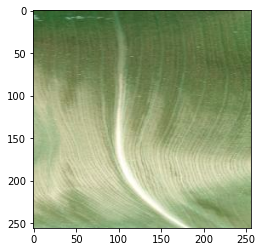

In [95]:
plt.imshow(b[1])